# This script prepares prior for the coming simulation study or EDA analysis. 

### Stage I: interpolate data for the area inside the operational area using SINMOD. 

In [1]:
from src.WGS import WGS
import os
import netCDF4
import numpy as np
import pandas as pd
from shapely.geometry import Polygon, Point

filepath = "/Users/yaolin/OneDrive - NTNU/MASCOT_PhD/Data/Nidelva/SINMOD_DATA/samples/samples_2022.05.11.nc"
path_border = "src/csv/polygon_border.csv"
path_obstacle = "src/csv/polygon_obstacle.csv"

sinmod = netCDF4.Dataset(filepath)
plg_border = pd.read_csv(path_border).to_numpy()
plg_obstacle = pd.read_csv(path_obstacle).to_numpy()
plg_b_sh = Polygon(plg_border)
plg_o_sh = Polygon(plg_obstacle)

timestamp = sinmod['time']
lat = np.array(sinmod['gridLats'])
lon = np.array(sinmod['gridLons'])
depth = np.array(sinmod['depth'])
salinity = np.array(sinmod['salinity'])

sal = np.nanmean(salinity[:, 0, :, :], axis=0)
lat = lat.flatten()
lon = lon.flatten()
sal = sal.flatten()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
plt.scatter(lon, lat, c=sal, cmap=get_cmap("BrBG", 10), vmin=10, vmax=30)
plt.plot(plg_border[:, 1], plg_border[:, 0], 'r-.')
plt.plot(plg_obstacle[:, 1], plg_obstacle[:, 0], 'r-.')
plt.colorbar()

In [ ]:
def border_contains(loc: np.ndarray) -> bool:
    """ Test if point is within the border polygon """
    lat, lon = loc
    point = Point(lat, lon)
    return plg_b_sh.contains(point)

def obstacle_contains(loc: np.ndarray) -> bool: 
    lat, lon = loc
    point = Point(lat, lon)
    return plg_o_sh.contains(point)

def get_legal_indices(lat, lon) -> np.ndarray: 
    ind = []
    for i in range(len(lat)):
        loc = np.array([lat[i], lon[i]])
        if border_contains(loc) and not obstacle_contains(loc):
            ind.append(True)
        else: 
            ind.append(False)
    return ind

In [ ]:
ind_legal = get_legal_indices(lat, lon)

In [ ]:
plt.scatter(lon[ind_legal], lat[ind_legal], c=sal[ind_legal], cmap=get_cmap("BrBG", 10), vmin=10, vmax=30)

In [ ]:
lat_l = lat[ind_legal]
lon_l = lon[ind_legal]
sal_l = sal[ind_legal]
x, y = WGS.latlon2xy(lat_l, lon_l)
dataset = np.stack((x, y, sal_l), axis=1)
df = pd.DataFrame(dataset, columns=['x', 'y', 'salinity'])
df.to_csv("prior/sinmod.csv", index=False)


# Section II: extract SINMOD surface salinity for visualizing in the paper.
- Remember to remove nan values so only valid values will be put on the map

In [5]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import get_cmap
from matplotlib.animation import FuncAnimation

timestamp = sinmod['time']
lat = np.array(sinmod['gridLats'])
lon = np.array(sinmod['gridLons'])
depth = np.array(sinmod['depth'])
salinity = np.array(sinmod['salinity'])

""" Extract legal indices. """
mask_value = -32768.0
lat_f = lat.flatten()
lon_f = lon.flatten()
sal_f = np.mean(salinity[:, 0, :, :], axis=0).flatten()
ind_legal = np.where(~(sal_f == mask_value))[0]

beta0 = 0.26095833
beta1 = 0.99898364
threshold = 26.81189868
sal_f = sal_f * beta1 + beta0

# plt.figure()
# plt.scatter(lon, lat, c=np.mean(salinity[:, 0, :, :], axis=0), cmap=get_cmap("BrBG", 10), vmin=10, vmax=30)
# plt.colorbar()
# plt.savefig("/Users/yaolin/Downloads/fig/S_{:03d}.png".format(i))

dataset = np.stack((lat_f[ind_legal], lon_f[ind_legal], sal_f[ind_legal]), axis=1)
df = pd.DataFrame(dataset, columns=['lat', 'lon', 'salinity'])
df.to_csv("/Users/yaolin/OneDrive - NTNU/MASCOT_PhD/Projects/GOOGLE/Docs/GIS/csv/sinmod_adjusted.csv", index=False)

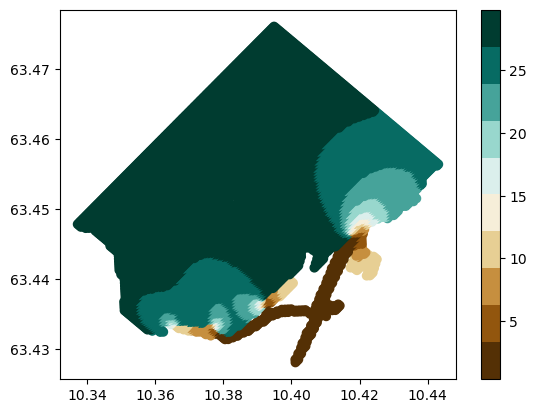

In [4]:
plt.scatter(df['lon'], df['lat'], c=df['salinity'], cmap=get_cmap("BrBG", 10))
plt.colorbar()
# for i in tqdm(range(salinity.shape[0])):
#     plt.figure()
#     plt.scatter(lon, lat, c=salinity[i, 0, :, :], cmap=get_cmap("BrBG", 10), vmin=10, vmax=30)
#     plt.colorbar()
#     plt.savefig("/Users/yaolin/Downloads/fig/S_{:03d}.png".format(i))
#     plt.close("all")
#     plt.show()

# Section III: create SINMOD data region for masking out values in visulization. 

In [32]:
box = np.array([[63.4441527, 10.3296626],
                [63.4761121, 10.3948786],
                [63.4528538, 10.45186239],
                [63.4209213, 10.38662725]])
df = pd.DataFrame(box, columns=['lat', 'lon'])
df.to_csv("/Users/yaolin/OneDrive - NTNU/MASCOT_PhD/Projects/GOOGLE/Docs/GIS/csv/sinmod_region.csv", index=False)

# Section IV, precalculate bivariate cumulative density function for z1, z2 and correlation coefficient. 

In [117]:
from scipy.stats import multivariate_normal
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from matplotlib.cm import get_cmap
from time import time
from numba import jit

sigma = 1.0
nugget = .4
eta = 4.5 / .7
threshold = 27.8


N = 25
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)

X, Y = np.meshgrid(x, y)
grid = np.stack((X.flatten(), Y.flatten()), axis=1)
Ngrid = grid.shape[0]

dm = cdist(grid, grid, metric='euclidean')
Sigma = sigma ** 2 * (1 + eta * dm) * np.exp(-eta * dm) 

mu = np.linalg.cholesky(Sigma) @ np.random.randn(Sigma.shape[0]).reshape(-1, 1)
mu += np.ones_like(mu) * 28



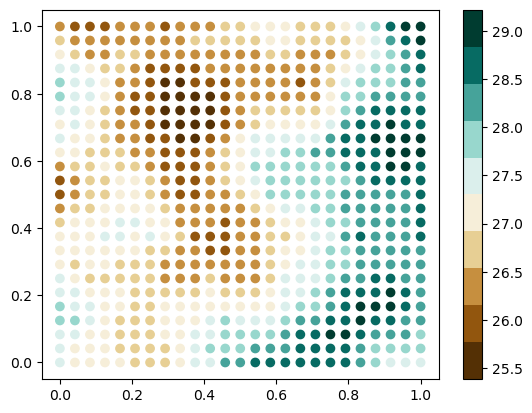

In [44]:
plt.scatter(grid[:, 0], grid[:, 1], c=mu, cmap=get_cmap("BrBG", 10))
plt.colorbar()
plt.show()


In [138]:

# @jit(nopython=True)
def get_cdf_table(z1: np.ndarray, z2: np.ndarray, rho: np.ndarray): 
    cdf = np.zeros([len(z1), len(z2), len(rho)])
    for i in range(z1.shape[0]): 
        for j in range(z2.shape[0]):
            for k in range(rho.shape[0]):
                cdf[i, j, k] = multivariate_normal.cdf([z1[i], z2[j]], mean=[0, 0], cov=[[1, rho[k]], [rho[k], 1]])
    return cdf

z1 = np.arange(-3, 3, .5)
z2 = np.arange(-3, 3, .5)
rho = np.arange(-.999999, 0, .1)

cdf1 = get_cdf_table(z1, z2, rho)


In [139]:
z1 = np.arange(-3, 3, .05)
z2 = np.arange(-3, 3, .05)
rho = np.arange(-.999999, 0, .01)
cdf = get_cdf_table(z1, z2, rho)

In [158]:
from sys import getsizeof
import os
filepath = os.getcwd() + "/prior/cdf.npz"

np.savez(filepath, z1=z1, z2=z2, rho=rho, cdf=cdf)
# os.system("open .")

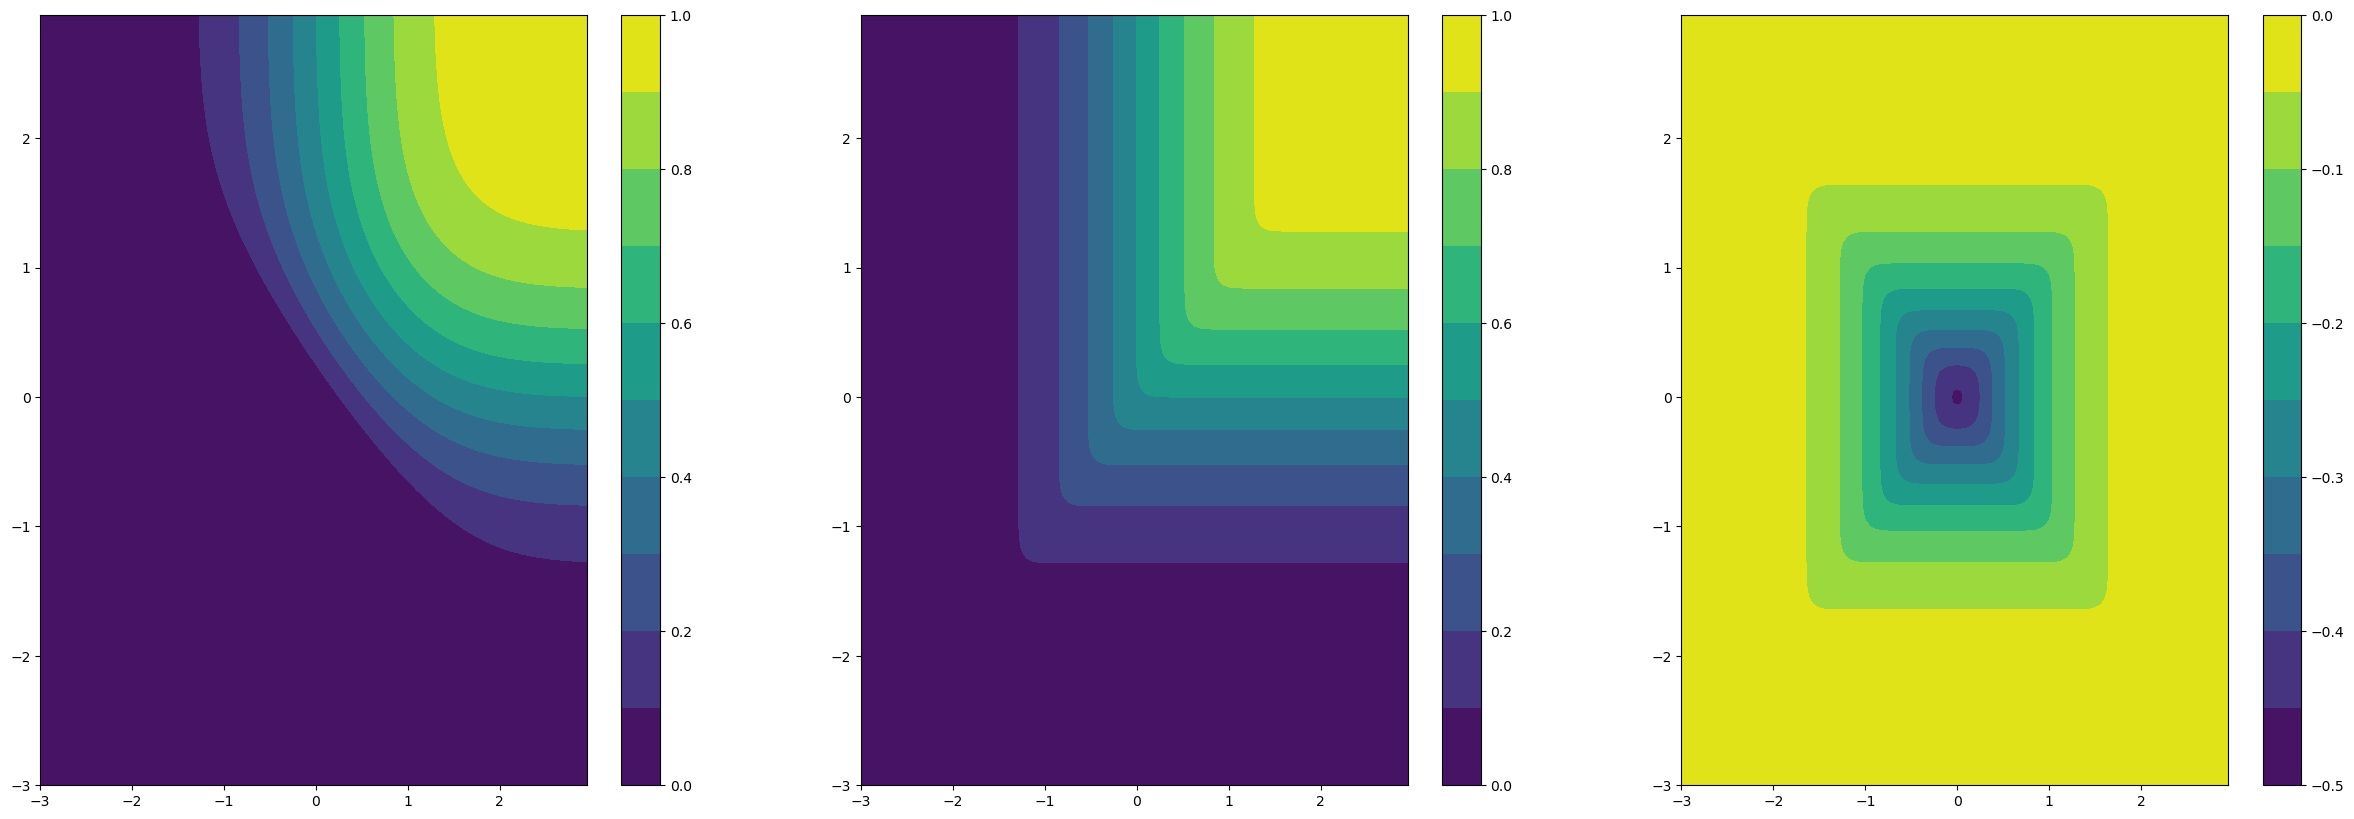

In [119]:
# [plt.contourf(z1, z2, cdf[:, :, i], levels=10) for i in range(rho.shape[0])] 
# plt.imshow(cdf[:, :, 0] - cdf[:, :, -1], origin='lower'); plt.colorbar(); plt.show()

plt.figure(figsize=(30, 10))
plt.subplot(131)
plt.contourf(z1, z2, cdf[:, :, 0], levels=10)
plt.colorbar()
plt.subplot(132)
plt.contourf(z1, z2, cdf[:, :, -1], levels=10)  
plt.colorbar()
plt.subplot(133)
plt.contourf(z1, z2, cdf[:, :, 0] - cdf[:, :, -1], levels=10)
plt.colorbar()
plt.show()

In [131]:

def get_eibv_analytical(mu: np.ndarray, sigma_diag: np.ndarray, vr_diag: np.ndarray) -> float:
    """
    Calculate the eibv using the analytical formula with a bivariate cumulative dentisty function.
    """
    eibv = .0
    for i in range(len(mu)):
        sn2 = sigma_diag[i]
        vn2 = vr_diag[i]

        sn = np.sqrt(sn2)
        m = mu[i]

        mur = (threshold - m) / sn

        sig2r_1 = sn2 + vn2
        sig2r = vn2

        eibv += multivariate_normal.cdf(np.array([0, 0]), np.array([-mur, mur]).squeeze(),
                                        np.array([[sig2r_1, -sig2r],
                                                  [-sig2r, sig2r_1]]).squeeze())
    return eibv

def get_eibv_analytical_sym(mu: np.ndarray, sigma_diag: np.ndarray, vr_diag: np.ndarray) -> float:
    """
    Calculate the eibv using the analytical formula with a bivariate cumulative dentisty function.
    """
    eibv = .0
    for i in range(len(mu)):
        sn2 = sigma_diag[i]
        vn2 = vr_diag[i]

        sn = np.sqrt(sn2)
        m = mu[i]

        mur = (threshold - m) / sn

        sig2r_1 = sn2 + vn2
        sig2r = vn2

        eibv += multivariate_normal.cdf(np.array([0, 0]), np.array([mur, -mur]).squeeze(),
                                        np.array([[sig2r_1, -sig2r],
                                                  [-sig2r, sig2r_1]]).squeeze())
    return eibv

@jit(nopython=True)
def get_eibv_analytical_fast(mu: np.ndarray, sigma_diag: np.ndarray, vr_diag: np.ndarray) -> float:
    """
    Calculate the eibv using the analytical formula but using a loaded cdf dataset. 
    """
    eibv = .0
    for i in range(len(mu)):
        sn2 = sigma_diag[i]
        vn2 = vr_diag[i]

        sn = np.sqrt(sn2)
        m = mu[i]

        mur = (threshold - m) / sn

        sig2r_1 = sn2 + vn2
        sig2r = vn2
        rho_coef = -sig2r / sig2r_1

        # print("z1: ", mur)
        # print("z2: ", mur)
        # print("rho: ", rho_coef)
        
        ind1 = np.argmin(np.abs(mur - z1))
        ind2 = np.argmin(np.abs(-mur - z2))
        ind3 = np.argmin(np.abs(rho_coef - rho))
        
        eibv += cdf[ind1][ind2][ind3]
        # eibv += multivariate_normal.cdf(np.array([0, 0]), np.array([-mur, mur]).squeeze(),
        #                                 np.array([[sig2r_1, -sig2r],
        #                                           [-sig2r, sig2r_1]]).squeeze())
    return eibv



In [132]:

def get_ei_field(method: int = 0) -> tuple:
    # t1 = time()
    eibv_field = np.zeros([Ngrid])
    ivr_field = np.zeros([Ngrid])
    for i in range(Ngrid):
        SF = Sigma[:, i].reshape(-1, 1)
        MD = 1 / (Sigma[i, i] + nugget)
        VR = SF @ SF.T * MD
        SP = Sigma - VR
        sigma_diag = np.diag(SP).reshape(-1, 1)


        vr_diag = np.diag(VR).reshape(-1, 1)
        if method == 0: 
            eibv_field[i] = get_eibv_analytical(mu, sigma_diag, vr_diag)
        elif method == 1: 
            eibv_field[i] = get_eibv_analytical_fast(mu, sigma_diag, vr_diag)
        else:
            eibv_field[i] = get_eibv_analytical_sym(mu, sigma_diag, vr_diag)

        ivr_field[i] = np.sum(np.diag(VR))
        # break
    # __eibv_field = normalize(eibv_field)
    # __ivr_field = 1 - normalize(ivr_field)
    # t2 = time()
    # print( "Total EI field takes: ", t2 - t1, " seconds.")
    return eibv_field, ivr_field

In [133]:
eibv0, ivr0 = get_ei_field(method=0)

In [134]:
eibv1, ivr1 = get_ei_field(method=1)

In [94]:
# eibv2, ivr2 = get_ei_field(method=2)

Total EI field takes:  31.40579891204834  seconds.


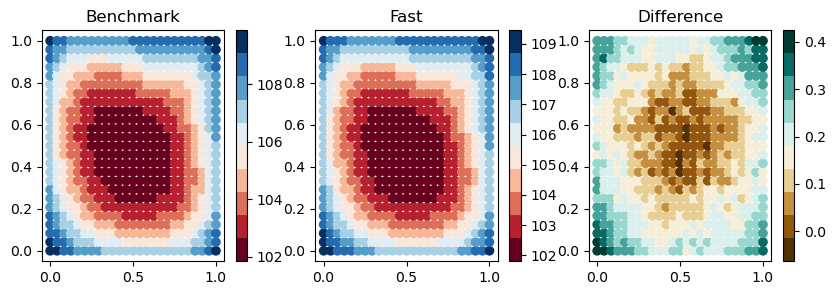

In [135]:
plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.scatter(grid[:, 0], grid[:, 1], c=eibv0, cmap=get_cmap("RdBu", 10))
plt.colorbar()
plt.title("Benchmark")
plt.subplot(132)
plt.scatter(grid[:, 0], grid[:, 1], c=eibv1, cmap=get_cmap("RdBu", 10))
plt.colorbar()
plt.title("Fast")
plt.subplot(133)
plt.scatter(grid[:, 0], grid[:, 1], c=eibv0 - eibv1, cmap=get_cmap("BrBG", 10))
plt.colorbar()
plt.title("Difference")
plt.show()


In [83]:
eibv0.shape

(625,)